In [1]:
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import shutil

INPUT_PATH='../output/generated/34_bpic_features'
feat_dir = list(tqdm(os.listdir(INPUT_PATH)))
source = ""
for feat_comb in feat_dir:
    logs = os.listdir(os.path.join(INPUT_PATH,feat_comb))
    for source in logs:
        if not "nan" in source:
            src = os.path.join(INPUT_PATH, feat_comb, source)
            dir_path = os.path.join(*os.path.split(INPUT_PATH)[:-1],"34bpics_gen")
            filename = source.replace("genEL", "").rsplit("_", 2)[0]
            feat_keys = feat_comb.split("_")[-2:]
            feat_values = source.replace(".xes","").rsplit("_",2)[-2:]
            key_values = "_".join([key+feat_values[i] for i, key in enumerate(feat_keys)])
            dst = os.path.join(dir_path, filename+"_"+key_values+".xes") 
            shutil.copyfile(src, dst)
            print("Saved ", dst)

In [2]:
gen_bpic_ft = pd.read_csv("../output/features/34bpics_gen_feat.csv")
bpi_ft = pd.read_csv("../data/34_bpic_features.csv").sort_values('log')
bpi_ft = bpi_ft[gen_bpic_ft.columns]
bpi_ft['source']='BPICs'
gen_bpic_ft['source']='GeneratedBPICs'

both_df = pd.concat([bpi_ft, gen_bpic_ft])
print(both_df.shape)
both_df.head()

(694, 9)


,log,ratio_unique_traces_per_trace,ratio_most_common_variant,ratio_top_10_variants,epa_normalized_variant_entropy,epa_normalized_sequence_entropy,epa_normalized_sequence_entropy_linear_forgetting,epa_normalized_sequence_entropy_exponential_forgetting,source
23,BPI2016_Complaints,0.438053,0.101770,0.424779,0.899497,0.683796,0.404685,0.470116,BPICs
24,BPI2016_Questions,0.797427,0.015650,0.282311,0.813468,0.756132,0.424910,0.506118,BPICs
25,BPI2016_Werkmap_Messages,0.002882,0.295803,0.714106,0.000000,0.000000,0.000000,0.000000,BPICs
20,BPIC15_1,0.975813,0.006672,0.121768,0.652855,0.610294,0.270241,0.363928,BPICs
0,BPIC15_2,0.995192,0.002404,0.103365,0.627973,0.602371,0.317217,0.390473,BPICs


In [3]:
import numpy as np
from sklearn.impute import SimpleImputer

benchmarked_ft = both_df.copy()
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(benchmarked_ft.select_dtypes(exclude=['object']))
imp_df = imp_mean.transform(benchmarked_ft.select_dtypes(exclude=['object']))
imp_df = pd.DataFrame(imp_df, columns = gen_bpic_ft.select_dtypes(exclude=['object']).columns)
print("Before:", len(benchmarked_ft.loc[:, benchmarked_ft.isna().any()].columns), "columns in", len(benchmarked_ft.loc[:, benchmarked_ft.isna().any()]), 'rows')
print("After:", len(imp_df.loc[:, imp_df.isna().any()].columns))

Before: 4 columns in 694 rows
After: 0


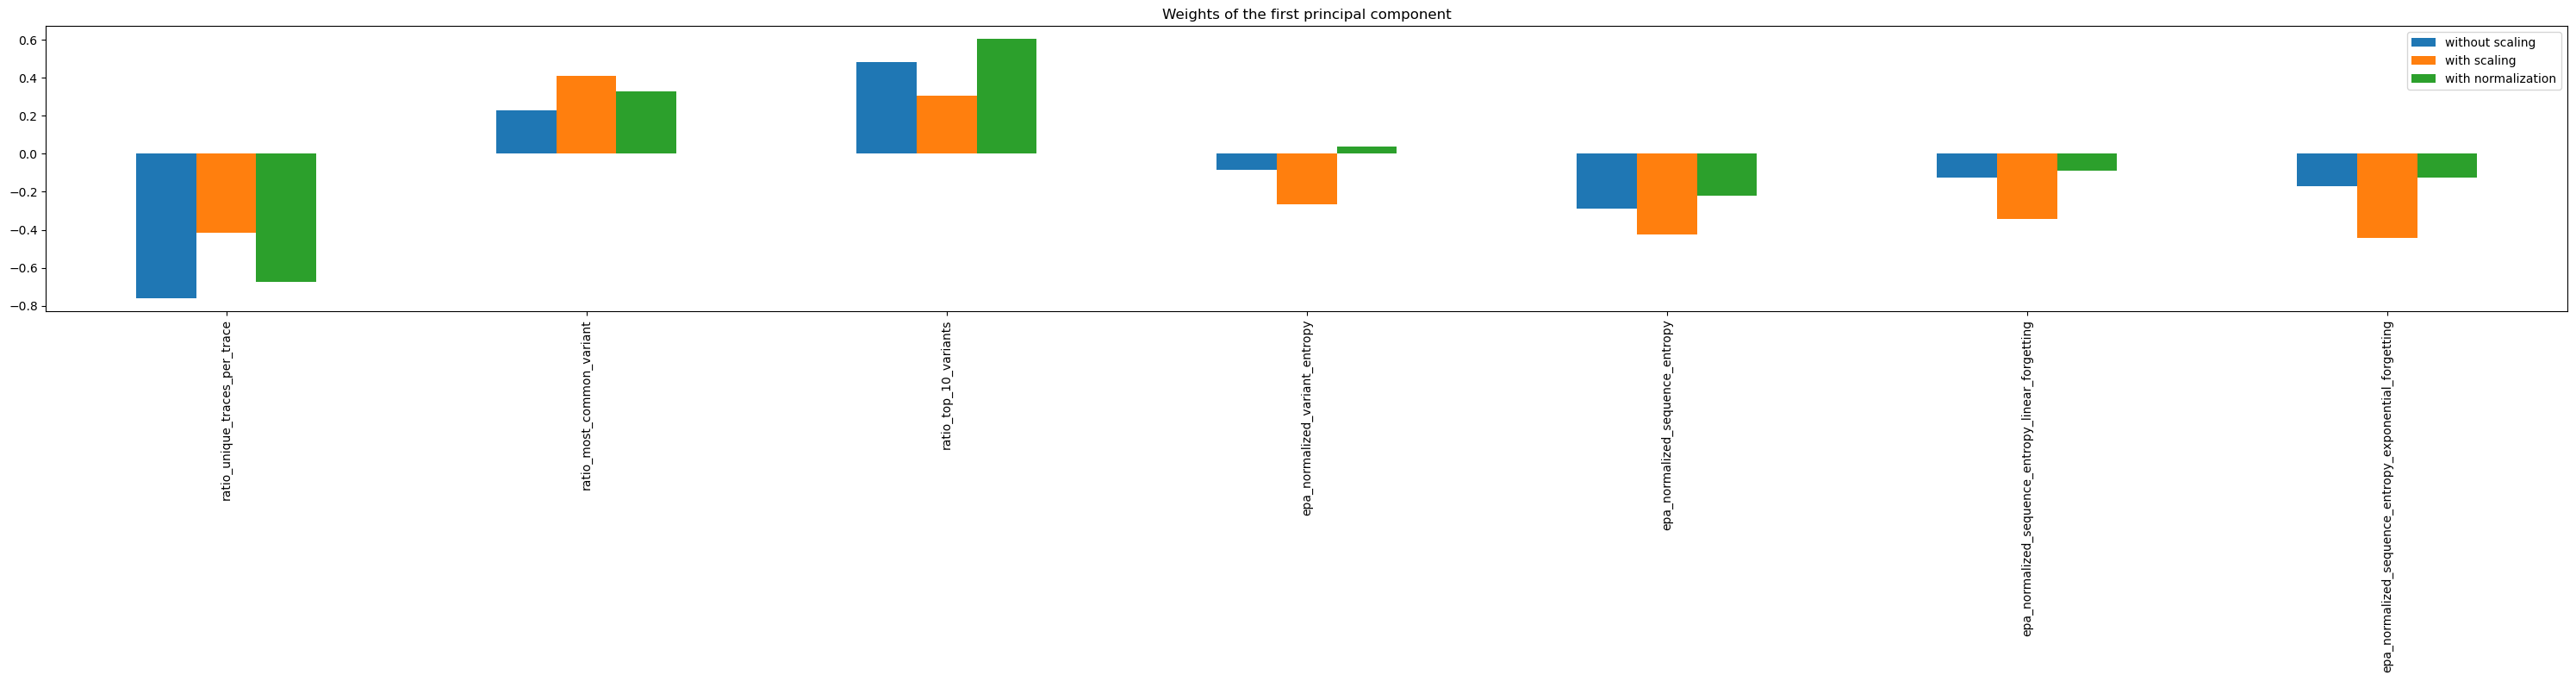

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt


X = imp_df
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X)
normed_X = Normalizer(norm="l2").fit_transform(X)


import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
norm_pca = PCA(n_components=2).fit(normed_X)


X_train_transformed = pca.transform(X)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)
X_train_norm_transformed = norm_pca.transform(normed_X)


first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component["with normalization"] = norm_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(30, 8)
)

_ = plt.tight_layout()

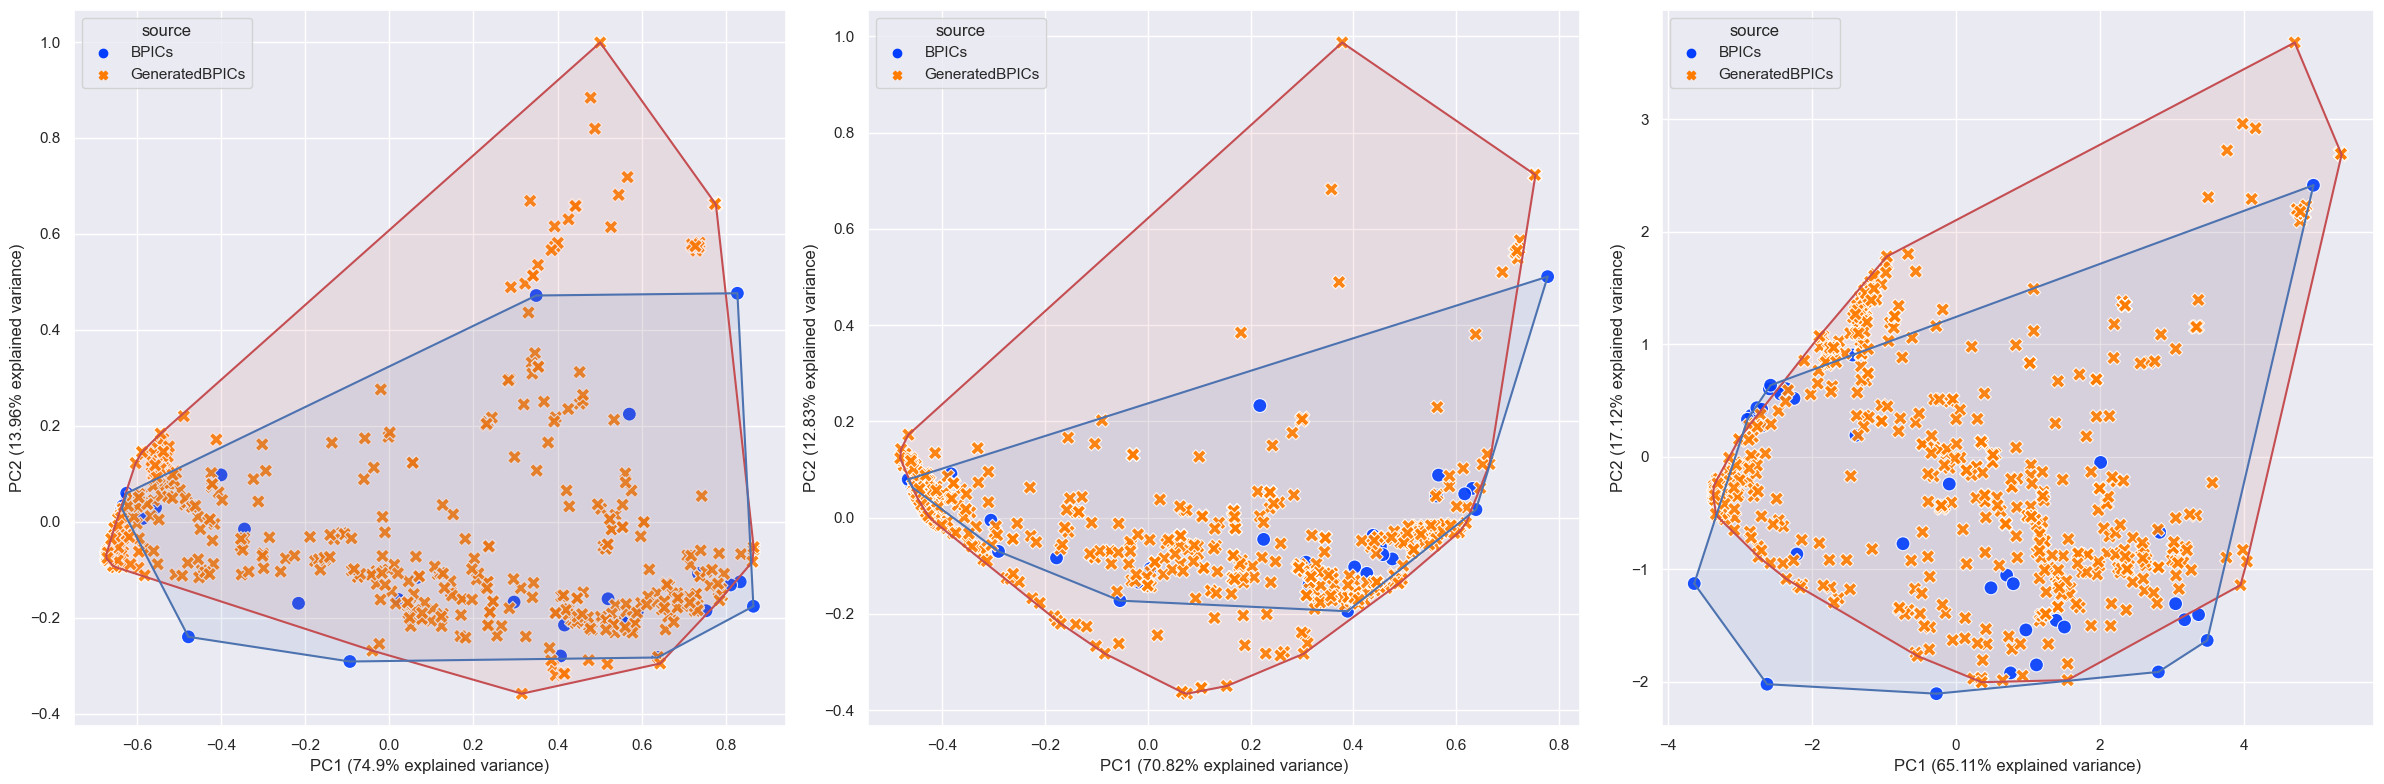

In [ ]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull


def plot_convex_hull(numbers, ax, style, color):
    hull = ConvexHull(numbers)
    for simplex in hull.simplices:
        ax.plot(numbers[simplex, 0], numbers[simplex, 1], style)
    ax.fill(numbers[hull.vertices,0], numbers[hull.vertices,1], color, alpha=0.1)

pca = PCA(n_components=2)

# Normalizer: By default, L2 normalization is applied to each observation so the that the values in a row have a unit norm. 
    # Unit norm with L2 means that if each element were squared and summed, the total would equal 1. 
    #Normalizer does transform all the features to values between -1 and 1. 
#norm_data = Normalizer(norm="l2").fit_transform(df.drop(["log"], axis=1))
norm_data = Normalizer(norm="l2").fit_transform(X)

#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. 
    #Unit variance means dividing all the values by the standard deviation.
scaler = StandardScaler()
sca_data = scaler.fit_transform(X)
#norm_data = Normalizer(norm="l2").fit_transform(norm_data)

sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24, 8))

X_new = pca.fit_transform(X)
df_pca = pd.DataFrame(X_new, columns=["PC1", "PC2"])
df_pca['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca[df_pca['source'] == 'GeneratedBPICs'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca[df_pca['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()

sns.scatterplot(ax=ax1, data=df_pca, x="PC1", y="PC2", palette="bright", hue='source',
                alpha=0.9, s=100, style="source")
plot_convex_hull(numbers_gen, ax1, 'r-', 'r')
plot_convex_hull(numbers_real, ax1, 'b-', 'b')

ax1.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax1.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")


X_new_norm = pca.fit_transform(norm_data)
df_pca_norm = pd.DataFrame(X_new_norm, columns=["PC1", "PC2"])
df_pca_norm['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca_norm[df_pca_norm['source'] == 'GeneratedBPICs'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_norm[df_pca_norm['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax2, 'r-', 'r')
plot_convex_hull(numbers_real, ax2, 'b-', 'b')

sns.scatterplot(ax=ax2, data=df_pca_norm, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax2.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax2.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")

X_new_sca = pca.fit_transform(sca_data)
df_pca_sca = pd.DataFrame(X_new_sca, columns=["PC1", "PC2"])
df_pca_sca['source']=benchmarked_ft['source'].to_numpy()
numbers_gen = df_pca_sca[df_pca_sca['source'] == 'GeneratedBPICs'][['PC1', 'PC2']].to_numpy()
numbers_real = df_pca_sca[df_pca_sca['source'] == 'BPICs'][['PC1', 'PC2']].to_numpy()
plot_convex_hull(numbers_gen, ax3, 'r-', 'r')
plot_convex_hull(numbers_real, ax3, 'b-', 'b')
sns.scatterplot(ax=ax3, data=df_pca_sca, x="PC1", y="PC2", palette="bright", hue='source', alpha=0.9, s=100, style="source")
ax3.set_xlabel(f"PC1 ({np.round(pca.explained_variance_ratio_[0]*100, 2)}% explained variance)")
ax3.set_ylabel(f"PC2 ({np.round(pca.explained_variance_ratio_[1]*100, 2)}% explained variance)")
plt.tight_layout()
# plt.show()
# plt.close()


In [14]:
import sys
from sklearn.neighbors import NearestNeighbors
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

features_df = both_df.copy()
features_all = features_df.sort_values('source').reset_index(drop=True).convert_dtypes()
X = imp_df#features_all.select_dtypes(exclude=['string'])
N_bpics = len(features_all[features_all['source']=='BPICs']['log'])
#print(features_all.sort_values('source')['log'][:N_bpics])

#print(X[N_bpics:])
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X[N_bpics:])
distances, indices = nbrs.kneighbors(X[:N_bpics])
#print(indices)
#print(distances)

nearest_to_bpics = [next(x for x in nearest if x > N_bpics) for nearest in indices]
#print([next(x for x in nearest if x > N_bpics) for nearest in indices])
nearest_to_bpics = nearest_to_bpics #list(range(0,N_bpics)) + nearest_to_bpics
nearest_to_bpics_ft = features_df.loc[nearest_to_bpics]
print(len(nearest_to_bpics_ft))

print(nearest_to_bpics_ft.shape)
nearest_log_names = nearest_to_bpics_ft['log'].to_list()
#print(len(nearest_log_names))
#nearest_to_bpics_ft[nearest_to_bpics_ft['source']=='GeneratedBPICs']

34
(34, 9)


,log,ratio_unique_traces_per_trace,ratio_most_common_variant,ratio_top_10_variants,epa_normalized_variant_entropy,epa_normalized_sequence_entropy,epa_normalized_sequence_entropy_linear_forgetting,epa_normalized_sequence_entropy_exponential_forgetting,source
336,BPI_Challenge_2019_enself03202_rt10v09464,0.506698,0.069016,0.543972,0.779617,0.616022,3.036804e-01,3.938080e-01,GeneratedBPICs
393,BPI_Challenge_2013_incidents_ense04047_enseef0...,0.850628,0.001861,0.189856,0.844979,0.583157,3.497828e-01,4.108511e-01,GeneratedBPICs
590,BPI2016_Werkmap_Messages_ense00_rutpt00029,0.002883,0.504587,0.504587,0.000000,0.000000,1.471012e-14,1.719539e-15,GeneratedBPICs
95,CoSeLoG_WABO_3_ense05964_enseef03564,1.000000,0.009901,0.099010,0.668197,0.576490,2.766754e-01,3.573579e-01,GeneratedBPICs
119,CoSeLoG_WABO_5_enself03468_rmcv00045,1.000000,0.004444,0.097778,0.678803,0.597103,3.240726e-01,3.963565e-01,GeneratedBPICs
119,CoSeLoG_WABO_5_enself03468_rmcv00045,1.000000,0.004444,0.097778,0.678803,0.597103,3.240726e-01,3.963565e-01,GeneratedBPICs
119,CoSeLoG_WABO_5_enself03468_rmcv00045,1.000000,0.004444,0.097778,0.678803,0.597103,3.240726e-01,3.963565e-01,GeneratedBPICs
119,CoSeLoG_WABO_5_enself03468_rmcv00045,1.000000,0.004444,0.097778,0.678803,0.597103,3.240726e-01,3.963565e-01,GeneratedBPICs
582,CoSeLoG_WABO_3_enseef03564_enve06543,0.343134,0.252326,0.631559,0.826341,0.455065,2.433509e-01,3.030966e-01,GeneratedBPICs
557,BPI_Challenge_2012_ense04231_enseef02756,0.155215,0.251112,0.791399,0.842648,0.423726,1.926455e-01,2.692967e-01,GeneratedBPICs


In [17]:
benchmarking_sample = nearest_to_bpics_ft[nearest_to_bpics_ft['source']=="GeneratedBPICs"]['log'].to_list()
print(len(benchmarking_sample))
'''
for sample in benchmarking_sample:
    src = os.path.join("../output/generated/34bpics_gen/",sample+".xes")
    dst = os.path.join("../output/generated/genBpic_sample/",sample+".xes")
    shutil.copyfile(src, dst)
    print("Saved ", dst)
'''
print(len(set(benchmarking_sample)))

34
22


In [34]:
bpi_pd = pd.read_csv("../output/benchmark/bpics_PDbenchmark.csv").sort_values('log')
gen_pd = pd.read_csv("../output/benchmark/genBpic_sample_bench.csv")
#gen_pd = gen_pd.sample(30)

print(gen_pd.shape, bpi_pd.shape)
bpi_pd['source']='BPICs'
gen_pd['source']='GeneratedBPICs'
both_pd = pd.concat([bpi_pd, gen_pd])
both_pd['log']=both_pd.apply(lambda x: x['log'].replace(".xes",""), axis=1)
both_pd['log']=both_pd.apply(lambda x: x['log'].replace("_processed",""), axis=1)
#print(both_pd.columns)
#print(both_df.columns)
both_pd = both_pd.dropna(axis=1)
print(both_pd.shape)

benchmarked_logs = both_pd['log'].unique()
#both_pd.head(20)

(38, 25) (13, 7)
(51, 8)


In [36]:
ft_perf = pd.concat([both_df.set_index('log'), both_pd.set_index('log')], axis=1, join="inner").reset_index()
ft_perf = ft_perf.T.drop_duplicates().T
print(len(ft_perf[ft_perf['source']=="BPICs"]['log']))
print(ft_perf.shape)

benchmarked_ft = ft_perf[both_df.columns]
benchmarked_pd = ft_perf[both_pd.columns]
print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
print(benchmarked_ft.shape)
print(len(benchmarked_pd[benchmarked_pd['source']=="BPICs"]['log']))
print(benchmarked_pd.shape)

13
(51, 15)
13
(51, 9)
13
(51, 8)


13
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'source'],
      dtype='object')
13
(38, 9)
(38, 8)
['rutpt', 'rmcv', 'rt10v', 'enve', 'ense', 'enself', 'enseef']


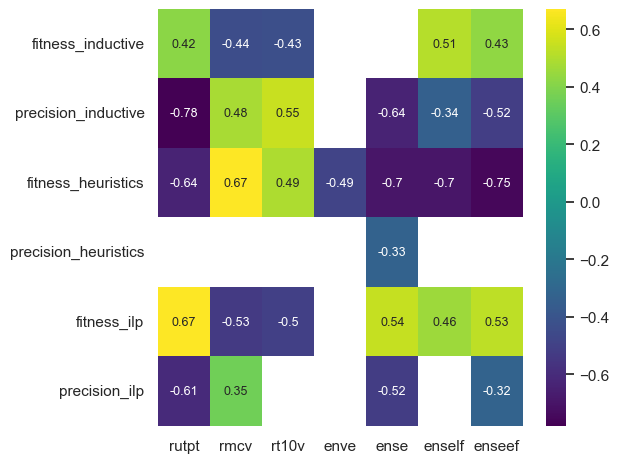

In [43]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.dirname("../gedi/utils/io_helpers.py"))
from io_helpers import get_keys_abbreviation


benchmarked_pdm = ft_perf[both_pd.columns]
print(len(benchmarked_pdm[benchmarked_pdm['source']=="BPICs"]['log']))
print(benchmarked_ft.columns)

print(len(benchmarked_ft[benchmarked_ft['source']=="BPICs"]['log']))
benchmarked_ft_plot = benchmarked_ft.copy()[benchmarked_ft['source']=="GeneratedBPICs"]#=="Generated"]
benchmarked_pdm_plot = benchmarked_pdm.copy()[benchmarked_pdm['source']=="GeneratedBPICs"]#=="Generated"]


print(benchmarked_ft_plot.shape)
print(benchmarked_pdm_plot.shape)
tmp = list(benchmarked_ft_plot.columns[1:-1])
df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
#print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
#print ("Benchmark_ft:", tmp)

for feature in benchmarked_ft_plot.columns:
    if feature != 'log' and feature != 'source':
        for metric in benchmarked_pdm_plot.columns:
            if metric != 'log' and metric != 'source':
                #print(feature, benchmarked_pdm.columns[1])
                stat, p = pearsonr(benchmarked_ft_plot[feature], benchmarked_pdm_plot[metric])
                #print(feature, metric, p, p <= 0.05)
                df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0.0)

feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
print(feature_keys)
df_tmp.columns=feature_keys
# df_tmp[pd.isnan()]

sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
ax = plt.gca()
sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=False, cbar=False, ax=ax)
#ax.set_title("P-values of features leading to process discovery metrics", fontsize=15)
plt.tight_layout()
#plt.savefig("../output/plots/pearson_feature_PDmetric", dpi=300)